Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


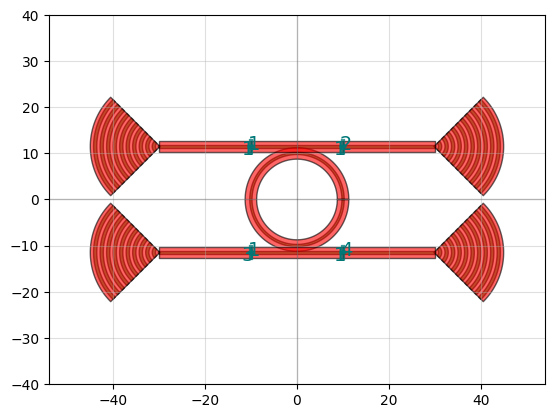

'ring_resonator_with_grating_couplers.gds'

In [ ]:
import phidl.geometry as pg
import phidl.path as pp
from phidl import Device, LayerSet, Group, quickplot as qp
import numpy as np

d = Device('dev1')

rr = Device('ring resonator')
gc = Device('grating coupler')

ls = LayerSet()

ls.add_layer(name='Si', gds_layer=0, color='yellow')  # Yellow for Si
ls.add_layer(name='SiO2_bot', gds_layer=1, color='blue')  # Blue for LiNbO3
ls.add_layer(name='LiNbO3', gds_layer=2, gds_datatype=2, color='green')  # Green for SiO2
ls.add_layer(name='SiO2_top', gds_layer=3, color='red')  # Red for substrate

ring_radius = 10.000
ring_width = .500
ring = pg.ring(radius=ring_radius, width=ring_width, layer=ls['LiNbO3'])
ring.add_port(name='posY', midpoint=(0, ring_radius + ring_width/2), width=0.5, orientation=90)
ring.add_port(name='negY', midpoint=(0, -ring_radius - ring_width/2), width=0.5, orientation=-90)
rr.add(ring)

wg_height = .500
wg_width = 20.000

wg_ring_dist = 1.00

wg1 = pg.straight(size=(wg_height, wg_width), layer=ls['LiNbO3'])
#wg1.add_port(name='thr1', midpoint=(0, wg_width/2), width=wg_height, orientation=180)
wg1.rotate(90).movex(wg_width/2).movey(ring_radius+ring_width/2+wg_ring_dist)
wg2 = pg.straight(size=(wg_height, wg_width), layer=ls['LiNbO3'])
#wg2.add_port(name='thr2', midpoint=(0, wg_width/2), width=wg_height, orientation=180)
wg2.mirror().rotate(90).movex(wg_width/2).movey(-(ring_radius+ring_width/2+wg_ring_dist))
wg_top = Device()
wg_top.add(wg1)
wg_bot = Device()
wg_bot.add(wg2)
#wg_ref.connect('thr1', ring_ref.ports['posY'])
#wg_ref2.connect('thr2', ring_ref.ports['negY'])

substrate_width = 2.500

ring_substrate = pg.ring(radius=ring_radius, width=substrate_width, layer=ls['SiO2_top'])
ring_substrate_ref = rr.add_ref(ring_substrate)

wg_movex=wg_width/2
wg_movey=ring_radius+ring_width/2+wg_ring_dist-(substrate_width-wg_height)/2

wg1_substrate = pg.straight(size=(substrate_width, wg_width), layer=ls['SiO2_top'])
wg1_substrate.rotate(90).movex(wg_movex).movey(wg_movey)
wg2_substrate = pg.straight(size=(substrate_width, wg_width), layer=ls['SiO2_top'])
wg2_substrate.mirror().rotate(90).movex(wg_movex).movey(-wg_movey)

wg_top.add(wg1_substrate)
wg_bot.add(wg2_substrate)

wg_top_ref = rr.add_ref(wg_top)
wg_bot_ref = rr.add_ref(wg_bot)

rr.add_port(name='1', midpoint=(-(wg_width/2), (substrate_width/2)+wg_movey), width=substrate_width, orientation=180)
rr.add_port(name='2', midpoint=(wg_width/2, (substrate_width/2)+wg_movey), width=substrate_width, orientation=0)
rr.add_port(name='3', midpoint=(-(wg_width/2), -((substrate_width/2)+wg_movey)), width=substrate_width, orientation=180)
rr.add_port(name='4', midpoint=(wg_width/2, -((substrate_width/2)+wg_movey)), width=substrate_width, orientation=0)

#grating = pg.grating(num_periods=10,period=500,fill_factor=0.5,width_grating=2000.0,length_taper=2000.0,width=200.0)

g_wg_width = .500 #np.sqrt(2*np.square(500))

g_width = g_wg_width*np.sqrt(2)
g_r = (3/2)*g_width+(1/2)*g_wg_width
g_multiple = 2*g_width

gratings = []
g_count = 10
for i in range(g_count):
    g = pg.arc(radius=g_r+(i*g_multiple), width=g_width, theta=90, layer=ls['LiNbO3']).mirror(p1=(0, 0), p2=(0, 1)).rotate(45)
    g_ref = gc.add(g)
    gratings.append(g_ref)

g_wg_arc = pg.arc(radius=g_width/4, width=g_width/2, theta=90, layer=ls['LiNbO3']).mirror(p1=(0, 0), p2=(0, 1)).rotate(45)
gc.add(g_wg_arc)
g_wg = pg.straight(size=(g_wg_width, wg_width), layer=ls['LiNbO3']).mirror(p1=(1, 1), p2=(0, 0)).movey(-g_wg_width/2).movex(-g_wg_width/2)
gc.add(g_wg)

g_substrate_r = (g_r + g_multiple * g_count - g_width/2)/2

g_substrate = pg.arc(radius=g_substrate_r,width=2*g_substrate_r,theta=90,layer=ls['SiO2_top']).mirror(p1=(0, 0), p2=(0, 1)).rotate(45)
gc.add(g_substrate)

g_wg_substrate = pg.straight(size=(substrate_width, wg_width), layer=ls['SiO2_top']).mirror(p1=(1, 1), p2=(0, 0)).movey(-substrate_width/2).movex(-(g_wg_width/2))
gc.add(g_wg_substrate)

gc.add_port(name='1', midpoint=(wg_width-(g_wg_width/2), 0), width=substrate_width, orientation=0)

rr1 = d.add_ref(rr)

gc1 = d.add_ref(gc)
gc1.connect('1', rr.ports['1'])

gc2 = d.add_ref(gc)
gc2.connect('1', rr.ports['2'])

gc3 = d.add_ref(gc)
gc3.connect('1', rr.ports['3'])

gc4 = d.add_ref(gc)
gc4.connect('1', rr.ports['4'])

qp(d)

# Save the device to a GDS file
d.write_gds('ring_resonator_with_grating_couplers.gds', unit=1e-6, precision=1e-9)